<a href="https://colab.research.google.com/github/anupj/PyTorchForDeepLearningBootcamp/blob/main/04_pytorch_custom_datasets_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before, but how do you get your own data into PyTorch?

One of the ways to do so is via: **custom datasets**.

## Domain libraries
PyTorch has both existing data loading functions and customisable data loading functions for [domains](https://pytorch.org/pytorch-domains) like vision, text, audio, recommendations etc.
e.g. [torchvision](https://pytorch.org/vision/stable/index.html), [torchdata - beta](https://pytorch.org/data/beta/index.html)

**Resources**
* Course Materials: https://www.learnpytorch.io/04_pytorch_custom_datasets/

## 0. Importing PyTorch and setting up device-agnostic code

In [52]:
import torch
from torch import nn

torch.__version__

'2.5.1+cu121'

In [53]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [54]:
!nvidia-smi

Wed Dec  4 06:30:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0              28W /  70W |    207MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get data

Our dataset is a subset of the [Food101 dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html)
>The Food-101 is a challenging data set of 101 food categories with 101,000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.

Our *mini* dataset contains 3 classes of food and only 10% of the images, so about ~75 training, and ~25 testing data points.

**Why?**
When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.
This will speed up experimentation cycles.

In [55]:
import requests
import zipfile
from pathlib import Path

# Setup a path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Check if image folder exists
if image_path.is_dir():
  print(f"{image_path} directory already exists...skipping downloading")
else:
  # create the image folder
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)
  # Download images data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get(url="https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data")
    f.write(request.content)
  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, and sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists...skipping downloading


## 2. Becoming one with the data (data prep and data exploration)

In [56]:
import os

def walk_through_dir(dir_path: Path) -> None:
  """Walks through a directory and its subdirectories, printing the number of subdirectories and files found at each level.

  This function is useful for exploring the structure and contents of a directory especially when working with directories. It provides a summary of the directory hierarchy and the number of files within each directory.

  Args:
    dir_path (str or pathlib.Path): The path to the directory you to explore.
  Returns:
    None: This function prints information to the console but does not return any values.

  Example:
    >>> walk_through_dir("data/my_dataset")
    There are 2 directories and 10 images in 'data/my_dataset'
    There are 0 directories and 5 images in 'data/my_dataset/train'
    There are 0 directories and 5 images in 'data/my_dataset/test'
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [57]:
walk_through_dir(dir_path=image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'


In [58]:
# Setup train and training paths
train_dir = image_path / "train"
test_dir = image_path / "test"

print(f"Training directory path is '{train_dir}'")
print(f"Testing directory path is '{test_dir}'")

Training directory path is 'data/pizza_steak_sushi/train'
Testing directory path is 'data/pizza_steak_sushi/test'


### 2.1 Visualising images

Let's write some code to:
1. Get all of the image paths
2. Pick a *random* image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with _images_, let's open the image with Python's PIL (or rather the `Pillow` fork of `PIL` library)
5. Show the image and print metadata

Random image path: data/pizza_steak_sushi/train/sushi/843815.jpg
Random image class: sushi
Random image height: 512
Random image width: 512
img type is: <class 'PIL.JpegImagePlugin.JpegImageFile'>
img shape is: (512, 512)


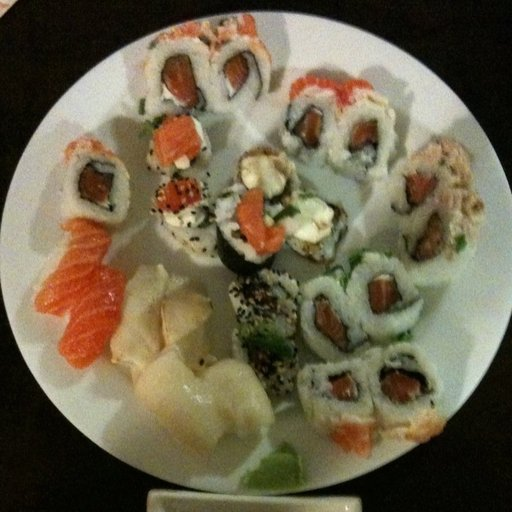

In [104]:
import random
from PIL import Image # NTS - where's Pillow fork?

# set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
# `image_class` is the name of the
# directory where the image is stored
image_class = random_image_path.parent.stem

# 4. Open image using PIL
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Random image class: {image_class}")
print(f"Random image height: {img.height}")
print(f"Random image width: {img.width}")
print(f"img type is: {type(img)}")
print(f"img shape is: {img.size}")
img


img_as_array shape is: (512, 512, 3)


(-0.5, 511.5, 511.5, -0.5)

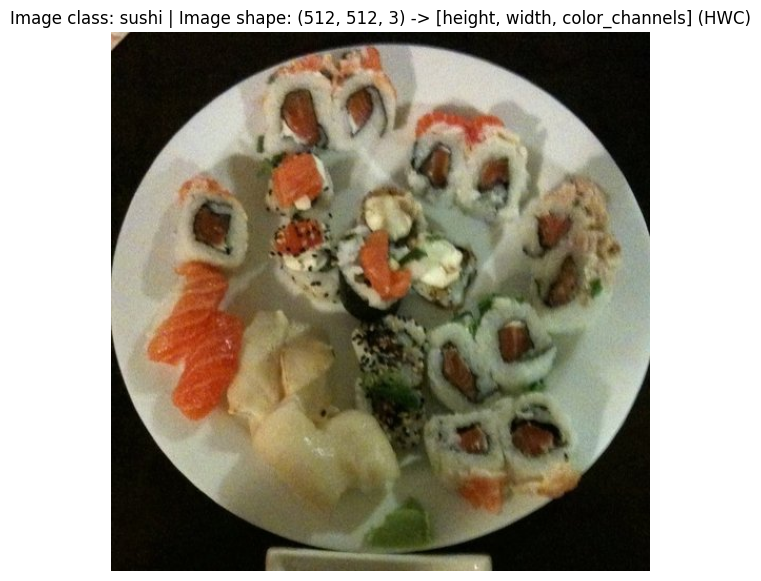

In [110]:
# Visualize the image using matplotlib

import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)
print(f"img_as_array shape is: {img_as_array.shape}")

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False)

## 3. Transforming data

Before we can use our image data with Pytorch:
1. Turn your target data into tensors
  - in our case, it will be numerical representation of our images
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`
  - whereas `dataset` stores the samples and their corresponding labels, `Dataloader` wraps an iterable around the `Dataset` to enable easy access to the samples.

In [61]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model and perform data augmentation - https://pytorch.org/vision/stable/transforms.html

In [62]:

# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64 from about 512x512
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image from a PIL image to a torch.Tensor
    transforms.ToTensor()
])


In [63]:
data_transform(img)

tensor([[[0.2392, 0.2784, 0.2902,  ..., 0.0667, 0.0706, 0.0706],
         [0.1804, 0.2510, 0.2980,  ..., 0.0667, 0.0706, 0.0706],
         [0.1843, 0.2627, 0.3059,  ..., 0.0706, 0.0667, 0.0667],
         ...,
         [0.5686, 0.5804, 0.5922,  ..., 0.9647, 0.9725, 0.9725],
         [0.5529, 0.5647, 0.5725,  ..., 0.7686, 0.7529, 0.7961],
         [0.4627, 0.4745, 0.4824,  ..., 0.3412, 0.3961, 0.7412]],

        [[0.1216, 0.1490, 0.1490,  ..., 0.0392, 0.0431, 0.0431],
         [0.1098, 0.1451, 0.1725,  ..., 0.0392, 0.0431, 0.0431],
         [0.1255, 0.1725, 0.2118,  ..., 0.0392, 0.0392, 0.0392],
         ...,
         [0.4471, 0.4549, 0.4627,  ..., 0.9569, 0.9725, 0.9804],
         [0.4353, 0.4471, 0.4510,  ..., 0.7137, 0.7059, 0.7765],
         [0.3647, 0.3725, 0.3804,  ..., 0.2706, 0.3373, 0.7176]],

        [[0.0275, 0.0353, 0.0471,  ..., 0.0078, 0.0039, 0.0039],
         [0.0471, 0.0471, 0.0510,  ..., 0.0078, 0.0039, 0.0078],
         [0.0510, 0.0667, 0.0980,  ..., 0.0078, 0.0078, 0.

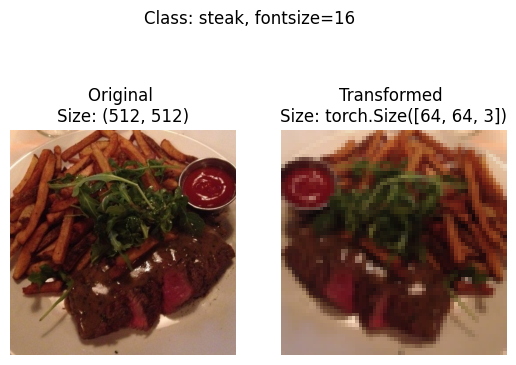

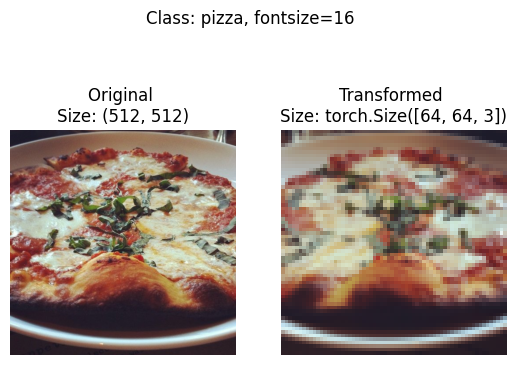

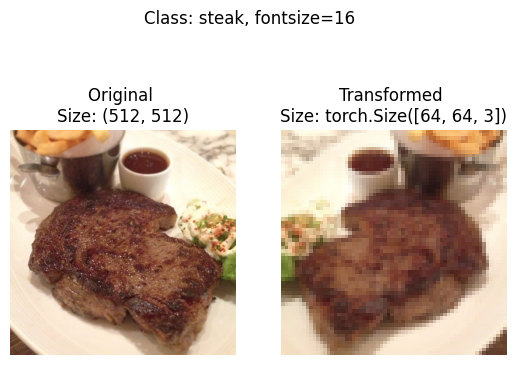

In [64]:
def plot_transformed_images(image_paths,
                           transform,
                           n=3,
                           seed=None):
  """Plots a series of random images from `image_paths`.
  Will open `n` image paths from `image_paths`, transform them with
  `data_transform` and plot them side by side.

  Args:
    image_paths(list): List of target image paths
    transform(PyTorch Transforms): Transforms to apply to images.
    n (int, optional): Number of images to plot. Defaults to 3.
    seed (int, optional): Random seed for the random generator. Defaults to `42`
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      # Note: `permute()` will change shape of image to suit matplotlib
      # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}, fontsize=16")

plot_transformed_images(image_path_list,
                       transform=data_transform,
                       n=3)

## 4. Option 1: Loading image data using `ImageFolder`

Alright, time to turn our images into a `Dataset` capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class `torchvision.datasets.ImageFolder`, where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

Let's test it out on our data folders train_dir and test_dir passing in transform=data_transform to turn our images into tensors.

In [65]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None #transforms to perform on labels (if necessary)
                                  )

test_data = datasets.ImageFolder(root=test_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  )

In [66]:
# Let's inspect our `Dataset`'s
# Get class names as a list
class_names = train_data.classes
print(class_names)

# Can also get class names as a dict
class_dict = train_data.class_to_idx
print(class_dict)

# Check the lengths
print(f"train data len: {len(train_data)}")
print(f"test data len: {len(test_data)}")

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}
train data len: 225
test data len: 75


Nice! Looks like we'll be able to use these to reference for later.

How about our images and labels?

How do they look?

We can index on our `train_data` and `test_data` `Dataset`'s to find samples and their target labels.

In [67]:
img, label = train_data[3][0], train_data[3][1]
print(f"Image tensor: \n{img}")
print(f"Image shape: \n{img.shape}")
print(f"Image datatype: \n{img.dtype}")
print(f"Image label: \n{label}")
print(f"Label datatype: \n{type(label)}")

Image tensor: 
tensor([[[0.0235, 0.0431, 0.1137,  ..., 0.2863, 0.2863, 0.2824],
         [0.0235, 0.0353, 0.0980,  ..., 0.2824, 0.2863, 0.2941],
         [0.0235, 0.0275, 0.0667,  ..., 0.2941, 0.2902, 0.2941],
         ...,
         [0.3373, 0.3529, 0.3882,  ..., 0.7059, 0.7059, 0.7020],
         [0.3294, 0.3490, 0.3686,  ..., 0.7098, 0.7020, 0.6863],
         [0.3020, 0.3333, 0.3569,  ..., 0.7098, 0.6941, 0.6745]],

        [[0.0157, 0.0353, 0.1216,  ..., 0.3608, 0.3608, 0.3490],
         [0.0157, 0.0275, 0.1059,  ..., 0.3686, 0.3647, 0.3608],
         [0.0157, 0.0235, 0.0667,  ..., 0.3765, 0.3765, 0.3725],
         ...,
         [0.3647, 0.3961, 0.4392,  ..., 0.8431, 0.8431, 0.8353],
         [0.3412, 0.3804, 0.4235,  ..., 0.8431, 0.8353, 0.8235],
         [0.3216, 0.3647, 0.4078,  ..., 0.8431, 0.8314, 0.8157]],

        [[0.0196, 0.0471, 0.1804,  ..., 0.5020, 0.4980, 0.4902],
         [0.0196, 0.0314, 0.1451,  ..., 0.5176, 0.5059, 0.5020],
         [0.0196, 0.0275, 0.0902,  ..., 0.5

Our images are now in the form of a tensor with shape `[3, 64, 64]` and the labels are in the form of an integer relating to a specific class (as referenced by the `class_to_idx` attribute).

How about we plot a single image tensor using `matplotlib`?

We'll first have to permute (rearrange the order of its dimensions)so that it's compatible.

Right now our image dimensions are in the format `CHW` but `matplotlib` prefers `HWC`

Original shape: torch.Size([3, 64, 64]) -> [CHW]
Permuted Image shape: torch.Size([64, 64, 3]) -> [HWC]


Text(0.5, 1.0, 'pizza')

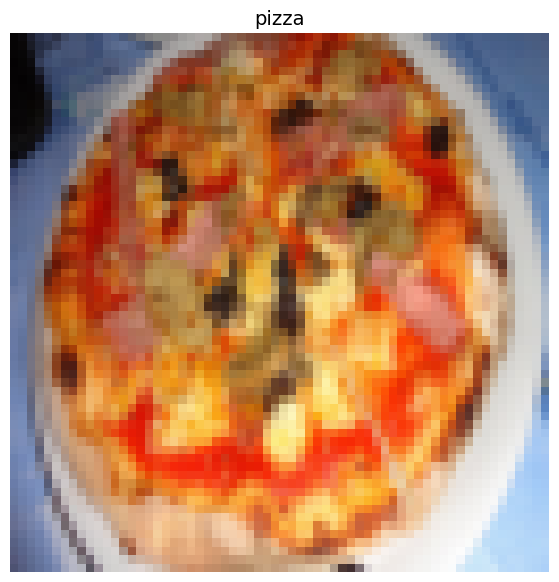

In [68]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [CHW]")
print(f"Permuted Image shape: {img_permute.shape} -> [HWC]")


# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1. Turn loaded images into `DataLoader`s

Turning our `Dataset`'s into `DataLoader`'s makes them iterable so a model can go through and learn the relationships between samples and targets (features and labels).

We'll use a `batch_size=1` and `num_workers=1` to keep things simple.

`num_workers` defines how many *subprocesses* will be created to load your data - higher the value, the more compute power PyTorch will use to load your data.

You could set it to `os.cpu_count()` to make use of all of the CPUs on the machine.

In [69]:
import os
print(f"os.cpu_count(): {os.cpu_count()}J")

from torch.utils.data import DataLoader

BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading
                              shuffle=True) # shuffle the data
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=False) # don't usually need to shuffle testing data

print(f"train_dataloader: \n{train_dataloader}")
print(f"test_dataloader: \n{test_dataloader}")

os.cpu_count(): 2J
train_dataloader: 
test_dataloader: 


In [70]:
# Wonderful, let's try it out and check the shapes
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, col_channel, h, w]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, col_channel, h, w]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data With a Custom Dataset

What if a pre-built Dataset creator like torchvision.datasets.ImageFolder() didn't exist?

Or one for your specific problem didn't exist?

Well, you could build your own.

We want it to:
1. load images from file
2. get *class names* from the `Dataset`
3. get *classes* as dictionary from the Dataset

But wait, what are the pros and cons of creating your own custom way to load Dataset's?

Pros:
- Can create `Dataset` out of almost anything
- Not limited to PyTorch pre-built `Dataset` functions.

Cons:
- Even if you could create a `Dataset` out of almost anything, it doesn't mean it will work
- Using a custom `Dataset` often results in writing more code, which could be prone to performance issues

In [71]:
# Let's start by importing the modules we'll need to create a custom `Dataset`
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

### 5.1 Creating a helper function to get class names

Let's write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.

We will:
1. Get the *class names* using `os.scandir()` to traverse a target directory
2. Raise an `error` if the *class names* aren't found
3. Turn the *class names* into a directory of numerical labels, one for each class

In [72]:
# Let's a small example before we write the full function

# Setup path for target dir
target_dir = train_dir
print(f"Target directory: {target_dir}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [73]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory.

  Assumes target directory is in standard image classification format.

  Args:
      directory (str): target directory to load classnames from.

  Returns:
      Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

  Example:
      find_classes("food_images/train")
      >>> (["class_1", "class_2"], {"class_1": 0, ...})
  """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names not found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

  # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx


In [74]:
# Let's test it
# find_classes(train_dir)
find_classes(test_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset we want to:
1. Subclass `torch.utils.data.Dataset`
2. Initialise our subclass with a target directory, as well as `transform` if we'd like to transform our data.
3. Create several attributes:
  * `paths` - paths of our images
  * `transform` - the transform we'd like to use
  * `classes` - a list of target classes
  * `class_to_idx` - a dict of the target classes mapped to integer labels
4. Create a function to *load images*, this fn will *open* an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [75]:
# 0. import Dataset
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # 👆 here `targ_dir` is either `test` or `train`, and `paths` *list* now contains all paths like `test/pizza/00001.jpg`

    # Setup transform
    self.transform = transform

    # Setup `classes` *list* and `class_to_idx` *dict*
    self.classes, self.class_to_idx = find_classes(targ_dir)
    # 👆 will assign `(['pizza', 'steak', 'sushi']` to `classes`, and  `{'pizza': 0, 'steak': 1, 'sushi': 2})` to `class_to_idx`

  # 4. Create a fn to load images
  def load_image(self, index: int) -> Image.Image:
    """ Opens an image via a path and returns it. """
    # remember `paths` is just a list of *all* the images in either the *train* or *test* dir
    image_path = self.paths[index] # what if someone passes an index that is out of bounds
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    """ Returns the total num of samples. """
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return PyTorch `Tuple` that contains `torch.Tensor` and `int` data type. Note that Tuple is not the same as a *dict* type
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """ Returns a PyTorch Tuple that contains a sample of data - Tensor data and target label in integer format """
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    # 👆 expects *path* in format - `data_folder/class_name/image.jpg`
    class_idx = self.class_to_idx[class_name]

    # finally, transform if necessary
    if self.transform:
      img = self.transform(img)

    # return image(data) and label
    return img, class_idx

In [76]:
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5), # data augmentation/manipulation
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [77]:
# Let's test out the `ImageFolderCustom` Dataset

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7be9c73ce830>,
 <__main__.ImageFolderCustom at 0x7be9c73cf2b0>)

In [78]:
len(train_data), len(train_data_custom)

(225, 225)

In [79]:
len(test_data), len(test_data_custom)

(75, 75)

In [80]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [81]:
test_data_custom.classes, test_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.3 Create a function to Display Random Images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize
2. Let's cap the number of images to visualize to 10 to prevent the display getting out of hand
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset
5. Setup a matplotlib plot
6. Loop through the random sample indexes and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [82]:
# 1. Create a fn to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if `n` is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, `n` shouldn't be larger than 10, setting it to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    # [col_channels, h, w] -> [h, w, col_channels]
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

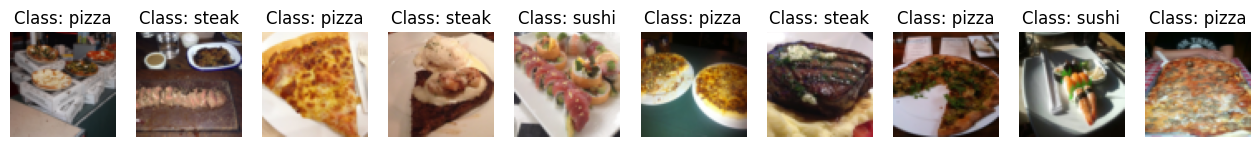

In [83]:
display_random_images(train_data_custom,
                      n=10,
                      display_shape=False,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [84]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS ,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7be9743fc2e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7be974233d00>)

In [85]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)
We've seen a couple of transforms on our data already but there's plenty more.

You can see them all in the `torchvision.transforms` [documentation](https://pytorch.org/vision/stable/transforms.html/).

The purpose of tranforms is to alter your images in some way.

That may be turning your images into a tensor (as we've seen before).

Or cropping it or randomly erasing a portion or randomly rotating them.

Doing these kinds of transforms is often referred to as data augmentation.

Data augmentation is the process of altering your data in such a way that you artificially increase the diversity of your training set.

Training a model on this artificially altered dataset hopefully results in a model that is capable of better generalization (the patterns it learns are more robust to future unseen examples).

You can see many different examples of data augmentation performed on images using torchvision.transforms in PyTorch's [Illustration of Transforms](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html) example.

But let's try one out ourselves.

Machine learning is all about harnessing the power of randomness and research shows that random transforms (like transforms.RandAugment() and transforms.TrivialAugmentWide()) generally perform better than hand-picked transforms.

The idea behind TrivialAugment is... well, trivial.

You have a set of transforms and you randomly pick a number of them to perform on an image and at a random magnitude between a given range (a higher magnitude means more instense).

The PyTorch team even used TrivialAugment it to train their latest state-of-the-art vision models.

In [86]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform *augmentation* on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])



> Note: You usually don't perform data augmentation on the test set. The idea of data augmentation is to to artificially increase the diversity of the training set to better predict on the testing set.

However, you do need to make sure your test set images are transformed to tensors. We size the test images to the same size as our training images too, however, inference can be done on different size images if necessary (though this may alter performance).

Let's test our data augmentation out!

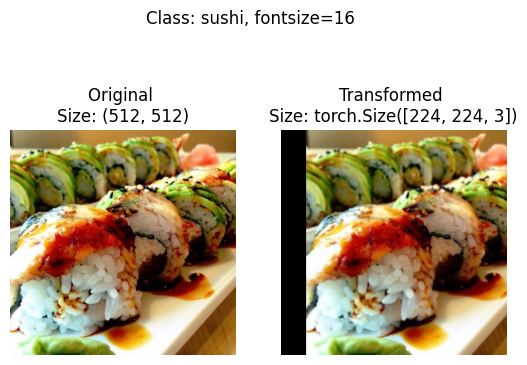

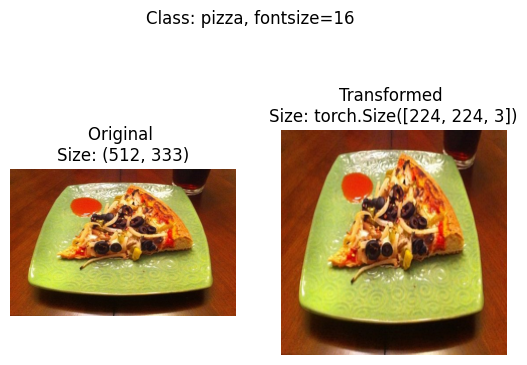

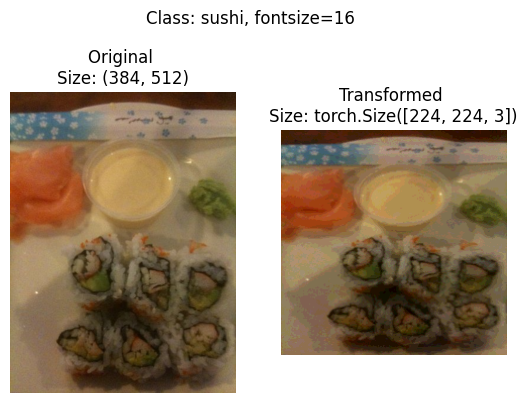

In [87]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [88]:
# Create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

Now we've got our *simple transform*, let's:
* *Load* our data - turning each of our `train` and `test` folders into a `Dataset` with `torchvision.datasets.ImageFolder`.
* Then into a `DataLoader` using `torch.utils.data.DataLoader`

In [89]:
# Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# Turn Dataset into DataLoader
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating test and train DataLoaders with batch size: {BATCH_SIZE} and num of workers: {NUM_WORKERS}")

# Create DataLoaders
train_dataloader_simple = DataLoader(
    dataset = train_data_simple,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
)

test_dataloader_simple = DataLoader(
    dataset = test_data_simple,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
)

print(f"Train DataLoader is: {train_dataloader_simple}")
print(f"Test DataLoader is: {test_dataloader_simple}")

Creating test and train DataLoaders with batch size: 32 and num of workers: 2
Train DataLoader is: <torch.utils.data.dataloader.DataLoader object at 0x7be97425d1b0>
Test DataLoader is: <torch.utils.data.dataloader.DataLoader object at 0x7be9c671b100>


### 7.2 Create TinyVGG model class

We are going to emulate the CNN model described [here](https://poloclub.github.io/cnn-explainer/)


In [90]:
class TinyVGG(nn.Module):
  """
  Copying the TinyVGG model described here https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        # Where did this in_features shape come from?
        # It's because each layer of our network compresses and changes the shape of our input data.
        nn.Linear(in_features = hidden_units * 13 * 13,
                  out_features = output_shape)
    )

  def forward(self, x: torch.Tensor):
    # calling it this way leverages the benefits of *operator fusion*
    # See Note below
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))



Note: One of the ways to speed up deep learning models computing on a GPU is to leverage operator fusion.

This means in the forward() method in our model above, instead of calling a layer block and reassigning x every time, we call each block in succession (see the final line of the forward() method in the model above for an example).

This saves the time spent reassigning x (memory heavy) and focuses on only computing on x.

See [Making Deep Learning Go Brrrr From First Principles](https://horace.io/brrr_intro.html) by Horace He for more ways on how to speed up machine learning models.

In [91]:
# Create model_0
torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [92]:
# Now let's try a forward pass

# 1. Get a batch of images and labels from our *simple* dataloader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
  pred = model_0(img_single.to(device))

# 4. Print out what's happening and
# convert model logits -> pred probs -> pred label
print(f"Output logits: \n{pred}\n")
print(f"Output prediction probabilities: \n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label: \n{torch.argmax(torch.softmax(pred, dim=1))}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits: 
tensor([[ 0.0208, -0.0020,  0.0095]], device='cuda:0')

Output prediction probabilities: 
tensor([[0.3371, 0.3295, 0.3333]], device='cuda:0')

Output prediction label: 
0

Actual label:
0


### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

`torchinfo` comes with a `summary()` method that takes a PyTorch model as well as an `input_shape` and returns what happens as a tensor moves through your model.

In [93]:
# Install torchinfo if it's not available, import if it is
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size = [1, 3, 64, 64])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loop functions

Specifically, we're going to make three functions
1. `train_step()` takes in a *model*, *train dataloader*, a loss fn, and an optimizer and trains the model on the dataloader
2. `test_step()` takes in a *model*, *test dataloader*, and a loss function and evaluates the model on the dataloader
3. `train()` performs **1** and **2** together for a given number of epochs and returns a results dictionary



In [94]:
# Create train_step()
def train_step( model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                device=device):
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # this outputs the logits

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumulate accuracy metrics across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

Now let's write the `test_step()` function.
The main difference here will be the `test_step()` won't take in an optimizer and therefore won't perform gradient descent.

In [95]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

The `train()` function will:
1. Take in a model, a `DataLoader` for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
2. Create an empty results dictionary for `train_loss`, `train_acc`, `test_loss`, and `test_acc` values
3. Loop through the training and test step functions for a number of epochs
4. Print out what's happening at the end of each epoch
5. Update the empty results dictionary with the updated metrics each epoch
6. Return the filled results dictionary

In [96]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create empty `results` dictionary
  results = { "train_loss": [],
             "train_acc": [],
              "test_loss": [],
              "test_acc": []
              }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
    )

    # Update results dictionary
    # Ensure all data is moved to CPU and converted to float for storage
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  return results

### 7.7 Train and evaluate model 0

In [117]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 100

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0979 | test_acc: 0.3409
Epoch: 2 | train_loss: 1.0835 | train_acc: 0.4453 | test_loss: 1.0778 | test_acc: 0.4223
Epoch: 3 | train_loss: 1.1063 | train_acc: 0.2812 | test_loss: 1.0818 | test_acc: 0.3826
Epoch: 4 | train_loss: 1.0755 | train_acc: 0.4766 | test_loss: 1.0778 | test_acc: 0.5047
Epoch: 5 | train_loss: 1.0663 | train_acc: 0.4023 | test_loss: 1.0517 | test_acc: 0.5038
Epoch: 6 | train_loss: 0.9958 | train_acc: 0.5820 | test_loss: 1.0467 | test_acc: 0.3106
Epoch: 7 | train_loss: 0.8855 | train_acc: 0.5625 | test_loss: 1.0784 | test_acc: 0.3409
Epoch: 8 | train_loss: 0.9375 | train_acc: 0.4688 | test_loss: 1.0949 | test_acc: 0.4025
Epoch: 9 | train_loss: 0.9128 | train_acc: 0.5156 | test_loss: 1.0373 | test_acc: 0.4754
Epoch: 10 | train_loss: 0.8075 | train_acc: 0.6211 | test_loss: 0.9921 | test_acc: 0.4432
Epoch: 11 | train_loss: 0.9010 | train_acc: 0.5273 | test_loss: 1.0346 | test_acc: 0.4735
Epoch: 12 | train_l

### 7.8 Plot the loss curves of Model 0

A **loss curve** is a way of tracking your model's progress over time; and they're a great way to see how your model performs on different datasets (e.g. training and test).

#### Sources:
* [A deep dive into Learning Curves in Machine Learning](https://wandb.ai/mostafaibrahim17/ml-articles/reports/A-Deep-Dive-Into-Learning-Curves-in-Machine-Learning--Vmlldzo0NjA1ODY0)
* [Learning Curve to identify Overfitting and Underfitting in Machine Learning](https://towardsdatascience.com/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5)

In [118]:
# Check the model_0_results key
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [119]:
# Let's create a *function* to plot the values in our `model_0_results` dictionary
def plot_training_curves(results: Dict[str, List[float]]):
  """Plots training curves for loss and accuracy of a results dictionary.

  Args:
    results (dict) : dictionary containing list of values, e.g.
    {
      "train_loss": [...],
      "train_acc": [....],
      "test_loss": [...],
      "test_acc": [...],
    }
  """

  # Get the loss values of the results dictionary (training and test)
  train_loss = results['train_loss']
  test_loss = results['test_loss']

  # Get the accuracy values of the results dictionary (training and test)
  train_accuracy = results['train_acc']
  test_accuracy = results['test_acc']


  # Figure out how many epochs there were
  epochs = range(len(results['train_loss']))


  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1) # 1 row, 2 columns, and this plt's index is 1
  plt.plot(epochs, train_loss, label = 'train_loss') # x-axis, y-axis, label
  plt.plot(epochs, test_loss, label = 'test_loss') # x-axis, y-axis, label
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2) # 1 row, 2 columns, and this plt's index is 2
  plt.plot(epochs, train_accuracy, label = 'train_accuracy') # x-axis, y-axis, label
  plt.plot(epochs, test_accuracy, label = 'test_accruracy') # x-axis, y-axis, label
  plt.title('Accruracy')
  plt.xlabel('Epochs')
  plt.legend()

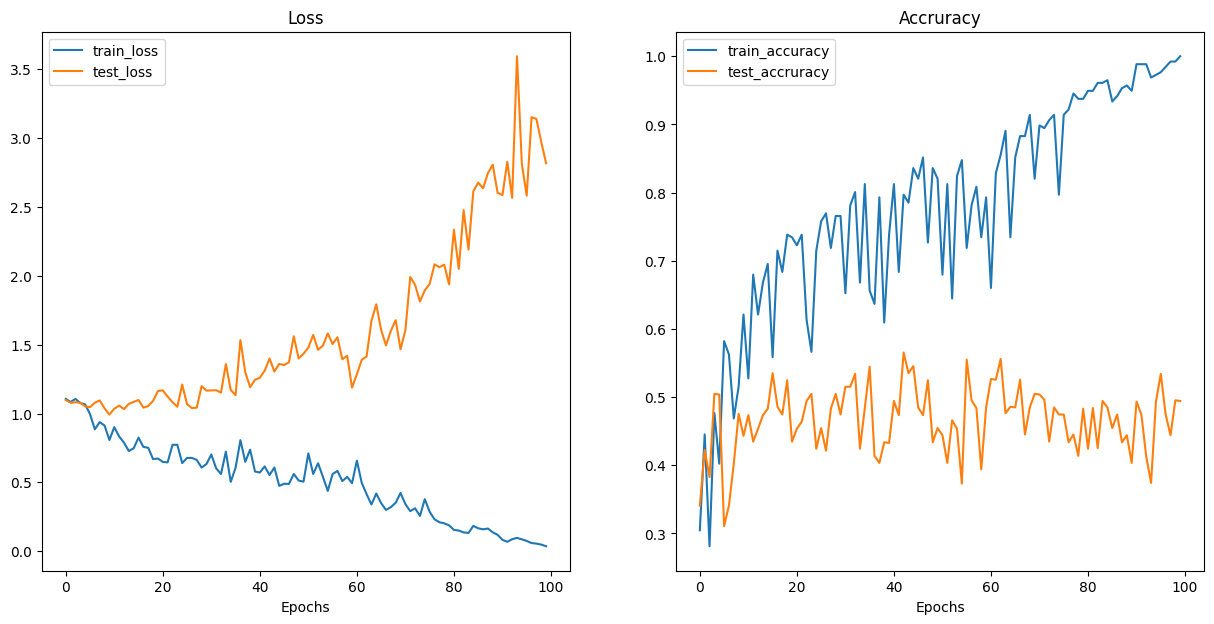

In [120]:
plot_training_curves(model_0_results)